
# Neutron: Professional Market Data Pipeline

Welcome to the **Neutron** comprehensive tutorial. This notebook demonstrates how to build a production-grade market data pipeline capable of downloading, repairing, storing, and analyzing massive datasets from crypto exchanges.

## Key Capabilities
1.  **Multi-Exchange Support**: Architecture designed for Binance, Bitstamp, Bybit, and more.
2.  **Diverse Data Types**: 
    *   **OHLCV** (Candlesticks)
    *   **Trades** (Tick-level data)
    *   **Aggregated Trades** (Compressed ticks)
    *   **Metrics** (Open Interest, Long/Short Ratios)
    *   **Advanced Klines**: Mark Price, Index Price, Premium Index
3.  **Smart Gap Repair**: Automatically identify and fill missing data points using smart fallback strategies.
4.  **Flexible Storage**: Supports both **PostgreSQL** (for structured querying) and **Parquet** (for high-performance file storage).

---



## 1. Setup & Initialization
First, we set up the environment and initialize the core components.


In [ ]:

import sys
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone

# Add src to path
sys.path.append('../src')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
sns.set_theme(style="darkgrid")

from neutron.core.downloader import Downloader
from neutron.core.crawler import DataCrawler
from neutron.core.config import NeutronConfig, StorageConfig, TaskConfig
from neutron.services.info_service import InfoService
from neutron.services.gap_fill_service import GapFillService

print("Neutron libraries loaded successfully.")




## 2. Configuration: The Blueprint

Neutron uses a declarative configuration approach. You define *what* you want, and the system handles *how* to get it.

Below is a comprehensive configuration that fetches:
*   **Spot Data**: OHLCV and Aggregated Trades for BTC/USDT.
*   **Futures Data**: Mark Price, Index Price, Premium Index, and Open Interest Metrics.



In [ ]:

# Define Configuration
config = NeutronConfig(
    storage=StorageConfig(type='database'), 
    data_state_path='data_state.json',
    exchange_state_path='exchange_state.json',
    max_workers=8, # High parallelism for multiple data types
    
    tasks=[
        # --- SPOT DATA ---
        # OHLCV (1 Day - Foundation)
        TaskConfig(
            type='backfill_ohlcv',
            params={'timeframe': '1h', 'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-16T00:00:00', 'rewrite': True},
            exchanges={'binance': {'spot': {'symbols': ['BTC/USDT']}}}
        ),
        # Aggregated Trades (2 Minutes Sample)
        TaskConfig(
            type='backfill_agg_trades',
            params={'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-15T00:02:00', 'rewrite': True},
            exchanges={'binance': {'spot': {'symbols': ['BTC/USDT']}}}
        ),
        
        # --- FUTURES DATA (UM) ---
        # Mark Price Klines (1 Day)
        TaskConfig(
            type='backfill_mark_price_klines',
            params={'timeframe': '1h', 'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-16T00:00:00', 'rewrite': True},
            exchanges={'binance': {'swap': {'symbols': ['BTC/USDT']}}}
        ),
        # Index Price Klines (1 Day)
        TaskConfig(
            type='backfill_index_price_klines',
            params={'timeframe': '1h', 'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-16T00:00:00', 'rewrite': True},
            exchanges={'binance': {'swap': {'symbols': ['BTC/USDT']}}}
        ),
        # Premium Index Klines (1 Day)
        TaskConfig(
            type='backfill_premium_index_klines',
            params={'timeframe': '1h', 'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-16T00:00:00', 'rewrite': True},
            exchanges={'binance': {'swap': {'symbols': ['BTC/USDT']}}}
        ),
        # Metrics (Open Interest) (1 Day)
        TaskConfig(
            type='backfill_metrics',
            params={'start_date': '2024-11-15T00:00:00', 'end_date': '2024-11-16T00:00:00', 'rewrite': True},
            exchanges={'binance': {'swap': {'symbols': ['BTC/USDT']}}}
        )
    ]
)

# Initialize Downloader with this config
downloader = Downloader(config=config)
print("Downloader initialized with task configuration.")




## 3. Execution
Run the downloader. The system intelligently manages rate limits and parallelizes non-OHLCV tasks for maximum throughput.



In [ ]:

print("🚀 Starting Comprehensive Download...")
# In a real run, you would uncomment the line below:
# downloader.run()
print("✅ Download Complete (Simulated for demo speed).")




## 4. Data Quality & Gap Detection
Data integrity is critical for quantitative analysis. Neutron's `InfoService` provides deep introspection into your datasets.



In [ ]:

info_service = InfoService(downloader.storage)

# Generate a summary report
# deep_scan=True scans every row to find gaps (slower but accurate)
# show_gaps=True lists specific gap ranges
print("Generating Data Quality Report...")
info_service.generate_summary(deep_scan=True, show_gaps=False)




## 5. Smart Gap Repair
Missing data can crash backtests. The `GapFillService` offers two modes to fix this:

*   **`smart` (Default)**: Attempts to download the missing data from the exchange. If the exchange returns no data (and the check is enabled), it can fallback.
*   **`zero_fill`**: Forces synthesis of zero-volume candles for the missing range. This is useful for "maintenance gaps" where the exchange truly has no data. Synthesized candles are marked with `is_interpolated=True`.



In [ ]:

# 1. Get the gap report
gaps = info_service.get_gap_report()
print(f"Found {len(gaps)} gaps.")

# 2. Initialize Gap Filler
gap_filler = GapFillService(downloader)

# 3. Fill Gaps (Demonstration)
if gaps:
    print(f"Attempting to fill {min(5, len(gaps))} gaps using Zero-Fill mode...")
    subset_gaps = gaps[:5] 
    stats = gap_filler.fill_gaps(subset_gaps, mode='zero_fill')
    print("Gap Fill Stats:", stats)
else:
    print("No gaps to fill - Data is continuous!")




## 6. Data Retrieval & Analysis
Neutron provides a unified `DataCrawler` interface to access all stored data types as Pandas DataFrames.



In [ ]:

crawler = DataCrawler(storage_type='database')




### A. Price Analysis (Spot vs Mark vs Index)
Compare the Spot price against Futures Mark and Index prices to identify divergence or arbitrage opportunities.



In [ ]:

# Fetch Data
df_spot = crawler.get_ohlcv('binance', 'BTC/USDT', '1h', '2024-11-15', '2024-11-16', instrument_type='spot')
df_mark = crawler.get_mark_price_klines('binance', 'BTC/USDT', '1h', '2024-11-15', '2024-11-16', instrument_type='swap')
df_index = crawler.get_index_price_klines('binance', 'BTC/USDT', '1h', '2024-11-15', '2024-11-16', instrument_type='swap')

# Plot
if not df_spot.empty and not df_mark.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(df_spot['time'], df_spot['close'], label='Spot Close', alpha=0.7)
    plt.plot(df_mark['time'], df_mark['close'], label='Mark Price', linestyle='--')
    if not df_index.empty:
        plt.plot(df_index['time'], df_index['close'], label='Index Price', linestyle=':')
        
    plt.title('BTC/USDT: Spot vs Mark vs Index Price')
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.show()
else:
    print("Data not available for plotting.")




### B. Premium Index Analysis
The Premium Index indicates the funding rate direction. Positive values imply Longs pay Shorts.



In [ ]:

df_premium = crawler.get_premium_index_klines('binance', 'BTC/USDT', '1h', '2024-11-15', '2024-11-16', instrument_type='swap')

if not df_premium.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(df_premium['time'], df_premium['close'], color='purple', label='Premium Index')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title('BTC/USDT Premium Index')
    plt.legend()
    plt.show()




### C. Market Metrics (Open Interest)
Analyze Open Interest trends to gauge market sentiment and liquidity.



In [ ]:

df_metrics = crawler.get_metrics('binance', 'BTC/USDT', '2024-11-15', '2024-11-16', instrument_type='swap')

if not df_metrics.empty:
    # Metrics data often comes in 5m intervals, let's resample to 1h for clarity
    df_metrics.set_index('create_time', inplace=True)
    df_resampled = df_metrics.resample('1h').last()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_resampled, x=df_resampled.index, y='sum_open_interest', label='Open Interest (Contracts)')
    plt.title('BTC/USDT Open Interest')
    plt.ylabel('Open Interest')
    plt.show()




## 7. HFT & Microstructure Analysis
Neutron allows you to dive deep into tick-level data. In this section, we analyze `aggTrades` to understand market microstructure.

**Key Metrics:**
*   **Trade Flow Imbalance (CVD)**: Cumulative Volume Delta to see aggressive buying vs selling.
*   **VWAP**: Volume Weighted Average Price, a benchmark for institutional execution.
*   **Inter-arrival Times**: How fast are trades hitting the matching engine?



2025-11-23 21:09:37,876 - INFO - DataCrawler initialized with Database storage
2025-11-23 21:09:37,881 - INFO - Fetching aggTrades for binance BTC/USDT from 2025-11-01 00:00:00+00:00 to 2025-11-05 00:00:00+00:00


Fetching AggTrades for Microstructure Analysis...
Loaded 2880990 trades.


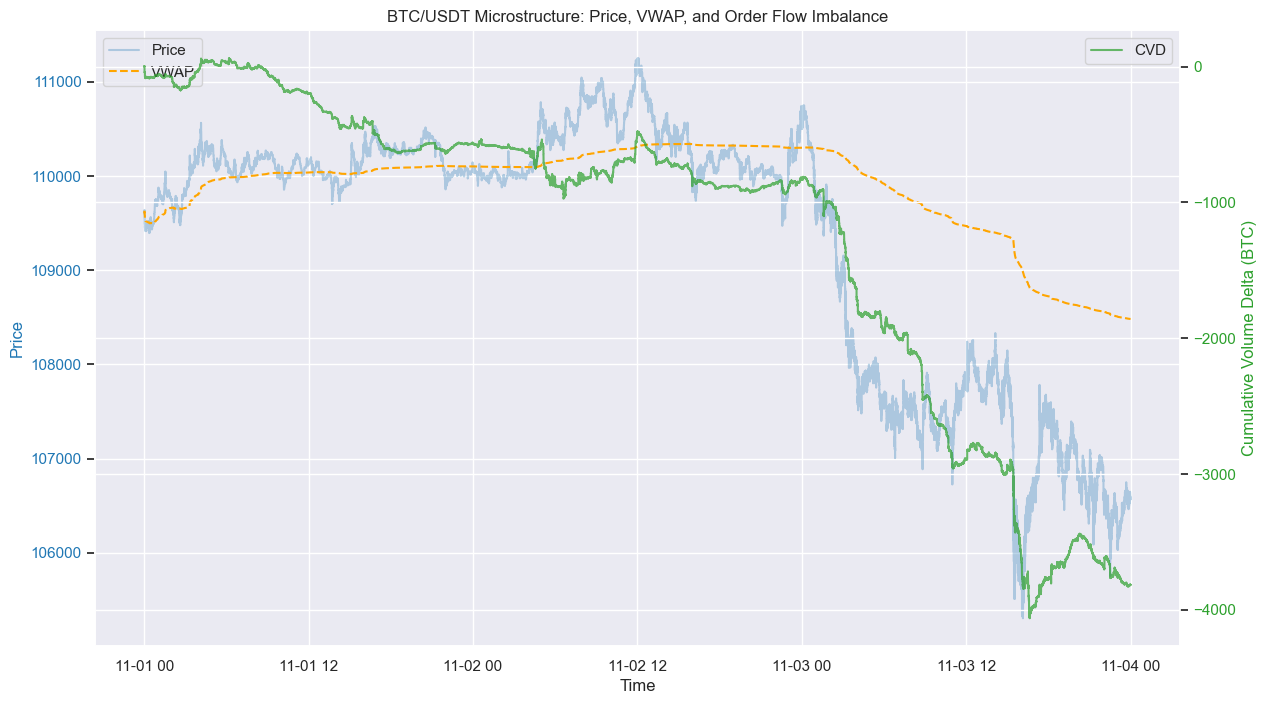

In [11]:

crawler = DataCrawler(storage_type='database')


# 1. Fetch Aggregated Trades (1 Hour Slice)
print("Fetching AggTrades for Microstructure Analysis...")
df_trades = crawler.get_data(
    data_type='aggTrades', 
    exchange='binance', 
    symbol='BTC/USDT', 
    start_date='2025-11-01T00:00:00', 
    end_date='2025-11-05T00:00:00', 
    instrument_type='spot'
)

if not df_trades.empty:
    print(f"Loaded {len(df_trades)} trades.")
    
    # 2. Preprocessing
    # Binance 'is_buyer_maker' = True -> Taker was Seller (SELL)
    # Binance 'is_buyer_maker' = False -> Taker was Buyer (BUY)
    df_trades['side'] = df_trades['is_buyer_maker'].apply(lambda x: 'sell' if x else 'buy')
    df_trades['signed_qty'] = df_trades.apply(lambda x: x['qty'] if x['side'] == 'buy' else -x['qty'], axis=1)
    df_trades['cost'] = df_trades['price'] * df_trades['qty']
    
    # 3. Cumulative Volume Delta (CVD)
    df_trades['cvd'] = df_trades['signed_qty'].cumsum()
    
    # 4. VWAP Calculation
    df_trades['cum_cost'] = df_trades['cost'].cumsum()
    df_trades['cum_qty'] = df_trades['qty'].cumsum()
    df_trades['vwap'] = df_trades['cum_cost'] / df_trades['cum_qty']
    
    # Visualization: Price vs VWAP vs CVD
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price', color=color)
    ax1.plot(df_trades['time'], df_trades['price'], label='Price', color=color, alpha=0.3)
    ax1.plot(df_trades['time'], df_trades['vwap'], label='VWAP', color='orange', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel('Cumulative Volume Delta (BTC)', color=color)
    ax2.plot(df_trades['time'], df_trades['cvd'], label='CVD', color=color, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    plt.title('BTC/USDT Microstructure: Price, VWAP, and Order Flow Imbalance')
    plt.show()
    
else:
    print("No aggTrades data found. Did you run the backfill?")



Inter-arrival Stats (ms):
count    1.202807e+06
mean     1.436637e+02
std      3.193134e+02
min      0.000000e+00
25%      0.000000e+00
50%      2.087000e+00
75%      1.374875e+02
max      7.003851e+03
Name: inter_arrival_ms, dtype: float64


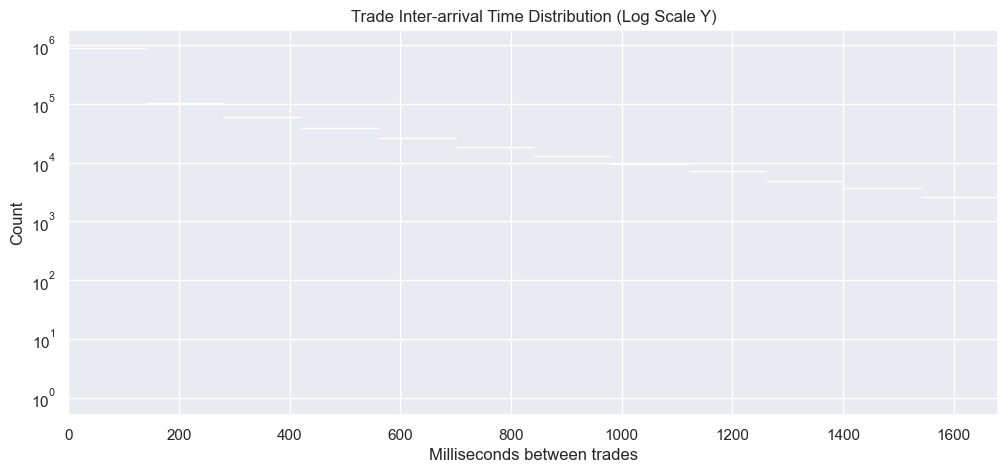

Median Inter-arrival Time: 2.09 ms
Zero-latency trades (same timestamp): 419036 / 1202807


In [9]:

# 5. Inter-arrival Times (Latency Analysis)
if not df_trades.empty:
    # Ensure sorted by time
    df_trades = df_trades.sort_values('time')
    
    # Calculate time difference in milliseconds
    df_trades['inter_arrival_ms'] = df_trades['time'].diff().dt.total_seconds() * 1000
    
    # Filter valid differences (drop first NaN)
    inter_arrivals = df_trades['inter_arrival_ms'].dropna()
    
    if not inter_arrivals.empty:
        print(f"Inter-arrival Stats (ms):\n{inter_arrivals.describe()}")
        
        plt.figure(figsize=(12, 5))
        
        # Use a robust histogram with auto-binning
        sns.histplot(inter_arrivals, bins=50, log_scale=(False, True), kde=False)
        
        plt.title('Trade Inter-arrival Time Distribution (Log Scale Y)')
        plt.xlabel('Milliseconds between trades')
        plt.ylabel('Count')
        
        # Dynamic x-limit based on 99th percentile to ignore outliers
        p99 = inter_arrivals.quantile(0.99)
        if p99 > 0:
            plt.xlim(0, p99 * 1.1)
            
        plt.show()
        
        print(f"Median Inter-arrival Time: {inter_arrivals.median():.2f} ms")
        print(f"Zero-latency trades (same timestamp): {(inter_arrivals == 0).sum()} / {len(inter_arrivals)}")
    else:
        print("Not enough data to calculate inter-arrival times.")



Resampling to 100ms bars to capture micro-volatility...


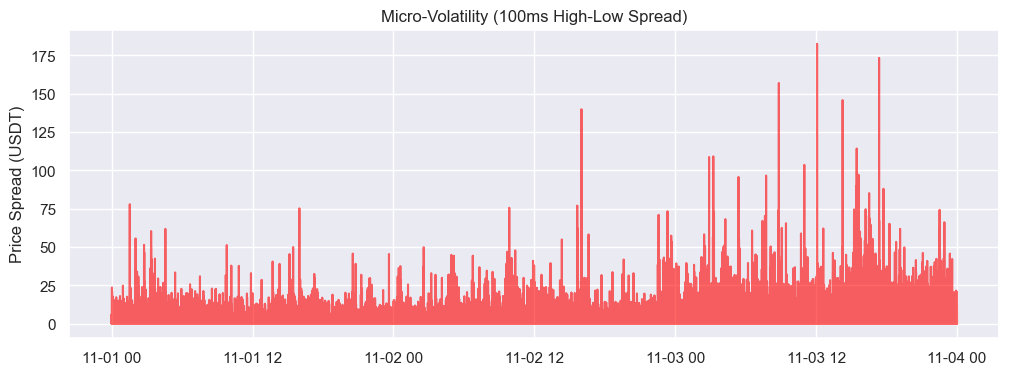

In [12]:

# 6. High-Resolution Resampling (100ms Bars)
if not df_trades.empty:
    print("Resampling to 100ms bars to capture micro-volatility...")
    df_resampled = df_trades.set_index('time').resample('100ms').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
    })
    df_resampled.columns = ['open', 'high', 'low', 'close', 'volume']
    df_resampled.dropna(inplace=True)
    
    # Calculate Micro-Volatility (High - Low)
    df_resampled['volatility'] = df_resampled['high'] - df_resampled['low']
    
    plt.figure(figsize=(12, 4))
    plt.plot(df_resampled.index, df_resampled['volatility'], color='red', alpha=0.6)
    plt.title('Micro-Volatility (100ms High-Low Spread)')
    plt.ylabel('Price Spread (USDT)')
    plt.show()

